In [1]:
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# real = "../input/real-and-fake-face-detection/real_and_fake_face/training_real/"
# fake = "../input/real-and-fake-face-detection/real_and_fake_face/training_fake/"
img_dim = 512

In [30]:
strategy = tf.distribute.MirroredStrategy()

In [18]:
# [train_dataset, validation_dataset] 

data = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/real-and-fake-face-detection/real_and_fake_face",
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(img_dim, img_dim),
    shuffle=True,
    seed=69,
#     validation_split=None,
#     subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
# Preprocessing
data = data.map(lambda x, y: (x/255, y))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 2041 files belonging to 2 classes.


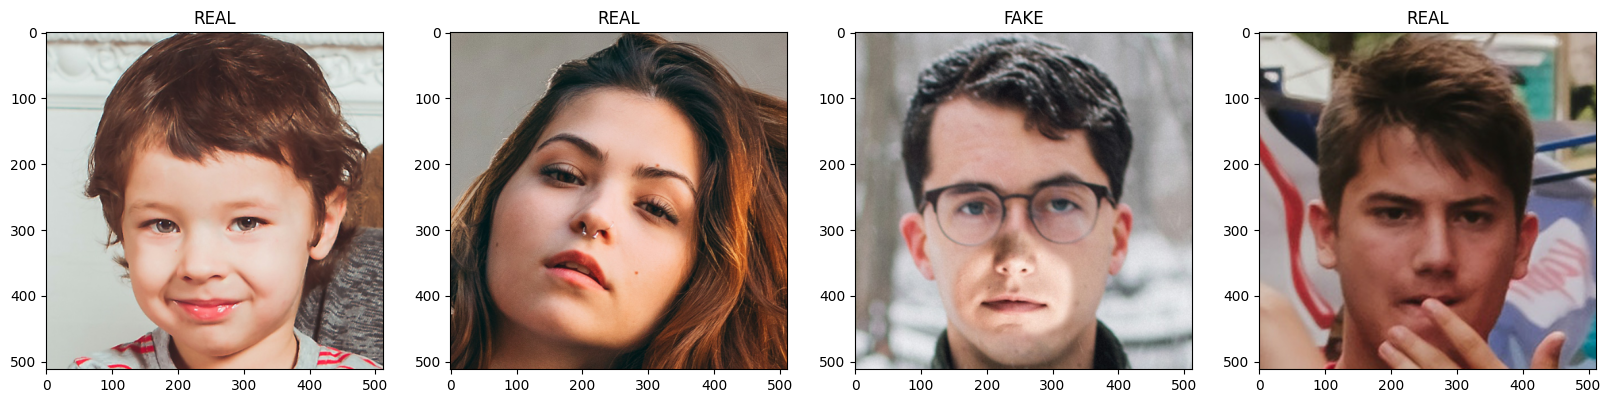

In [5]:
# 1 = REAL
# 0 = FAKE
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text("REAL" if batch[1][idx] == 1 else "FAKE")

In [25]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)+1

In [27]:
data_train = data.take(train_size)
data_val = data.skip(train_size).take(val_size)
data_test = data.skip(train_size+val_size).take(test_size)

In [10]:
#GPT model 1
model = keras.Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_dim, img_dim, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256, activation='relu'),

    Dense(1, activation='sigmoid')
])

In [29]:

#YT model 1 using rn
kernel_dim = 3
strides = 1
model = keras.Sequential([
    Conv2D(filters = 16, kernel_size = (kernel_dim, kernel_dim), strides = strides, activation='relu', input_shape=(img_dim, img_dim, 3), padding='same'),
    MaxPooling2D(),
    
    Conv2D(filters = 32, kernel_size = (kernel_dim, kernel_dim), strides = strides, activation='relu', padding='same'),
    MaxPooling2D(),
    
    Conv2D(filters = 16, kernel_size = (kernel_dim, kernel_dim), strides = strides, activation='relu', padding='same'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(256, activation='relu'),
    
    Dense(1, activation='sigmoid')
])


In [3]:
class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, stride=1, padding='valid'):
        super().__init__()
        self.conv = Conv2D(filters, kernel_size, stride, padding)
        self.norm = BatchNormalization()
        self.relu = layers.LeakyReLU(0.2)
    
    def call(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [32]:
with strategy.scope():
    model = keras.Sequential([
        layers.Input([img_dim, img_dim, 3]),
        ConvBlock(32, 3),
        MaxPooling2D(),
        ConvBlock(64, 3),
        MaxPooling2D(),
        ConvBlock(128, 3),
        MaxPooling2D(),
        ConvBlock(256, 3),
        layers.AveragePooling2D(),
        Dropout(0.1),
        ConvBlock(512, 3),
        ConvBlock(512, 3),
        layers.AveragePooling2D(),
        Flatten(),
        Dropout(0.1),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]

In [33]:
with strategy.scope():
    history = model.fit(
        data_train,
        validation_data=data_val,
        epochs=50,
        callbacks=callbacks
    )

Epoch 1/50


2023-05-27 15:39:12.316142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 [==============================] - 79s 1s/step - loss: 4.1313 - accuracy: 0.5547 - val_loss: 0.8533 - val_accuracy: 0.5505
Epoch 2/50
44/44 [==============================] - 56s 1s/step - loss: 1.4860 - accuracy: 0.5561 - val_loss: 0.8039 - val_accuracy: 0.4519
Epoch 3/50
44/44 [==============================] - 55s 1s/step - loss: 0.7487 - accuracy: 0.5909 - val_loss: 0.7026 - val_accuracy: 0.5529
Epoch 4/50
44/44 [==============================] - 56s 1s/step - loss: 0.6863 - accuracy: 0.6001 - val_loss: 0.6980 - val_accuracy: 0.5505
Epoch 5/50
44/44 [==============================] - 58s 1s/step - loss: 0.6564 - accuracy: 0.6342 - val_loss: 0.6773 - val_accuracy: 0.6130
Epoch 6/50
44/44 [==============================] - 58s 1s/step - loss: 0.6411 - accuracy: 0.6378 - val_loss: 0.6789 - val_accuracy: 0.5457
Epoch 7/50
44/44 [==============================] - 55s 1s/step - loss: 0.6297 - accuracy: 0.6520 - val_loss: 0.6790 - val_accuracy: 0.5769
Epoch 8/50
44/44 [=============

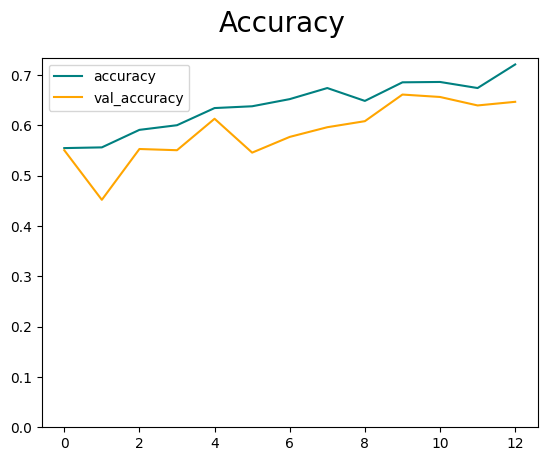

In [35]:
fig_acc=plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig_acc.suptitle('Accuracy', fontsize=20)
plt.ylim(ymin=0)  
plt.legend(loc="upper left")
plt.show()

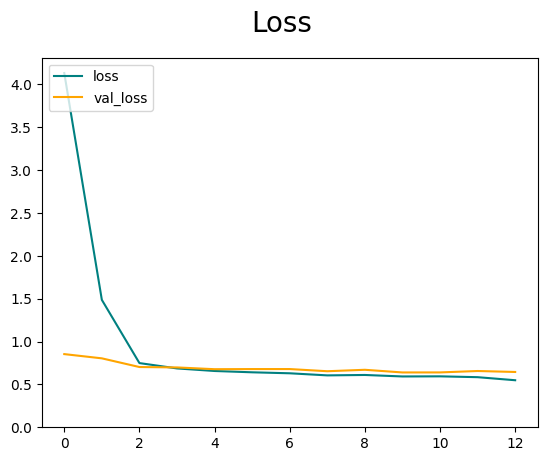

In [36]:
fig_loss=plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig_loss.suptitle('Loss', fontsize=20)
plt.ylim(ymin=0)  
plt.legend(loc="upper left")
plt.show()

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
bin_accuracy = BinaryAccuracy()
for batch in data_test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    bin_accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 96ms/step


In [40]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy: {bin_accuracy.result().numpy()}')

Precision:0.6268656849861145, Recall:0.7924528121948242, Accuracy: 0.6682027578353882


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'testmodel.h5'))